In [1]:
import sys
sys.path.append('../')
import torch
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
from model import NetV2
from torch.utils.data import DataLoader, SequentialSampler
from tqdm import tqdm
from torch.optim import Adam

### Control experiment: Not using masks and no dropout
This notebook evaluates the performance of not using any masks and no dropout layer

In [2]:
transform = transforms.Compose([
    transforms.RandomRotation(degrees=50),
    transforms.ToTensor(), transforms.GaussianBlur(kernel_size=5, sigma=(4, 5)),  # Stronger blur
    transforms.Lambda(lambda x: torch.flatten(x)),
])

In [3]:
dataset1 = datasets.MNIST('../data', train=True, download=True,
                       transform=transform)
dataset2 = datasets.MNIST('../data', train=False,
                       transform=transform)


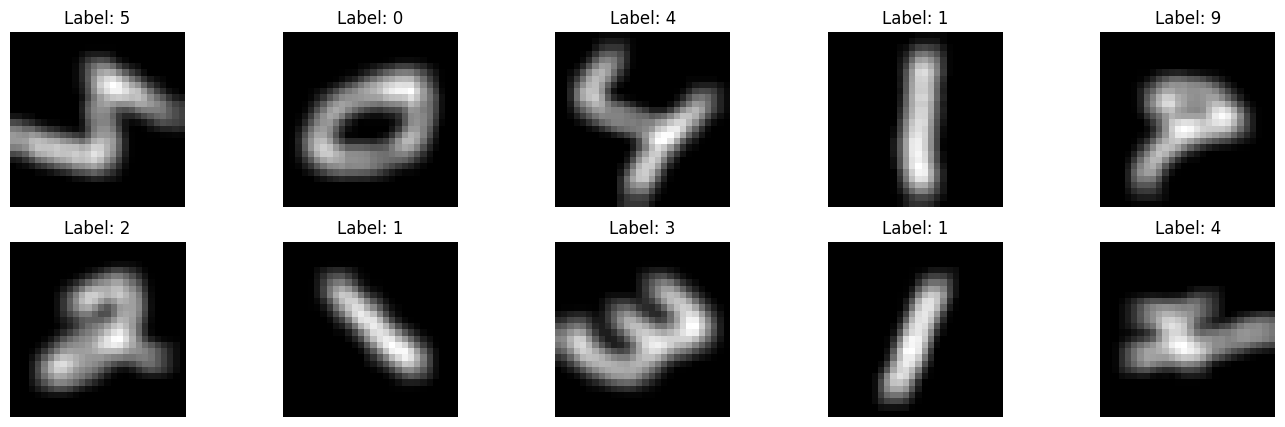

In [4]:
num_images = 10

# Plot multiple images
fig, axes = plt.subplots(2, num_images // 2, figsize=(17, 5))

for i in range(num_images):
    image, label = dataset1[i]  # Get image and label
    image_np = image.reshape(28, 28).squeeze().numpy()  # Convert to NumPy

    ax = axes[i // (num_images // 2), i % (num_images // 2)]
    ax.imshow(image_np, cmap="gray")
    ax.set_title(f"Label: {label}")
    ax.axis("off")

In [5]:
BATCH_SIZE = 32
EPOCHS = 10
NUM_MASKS = 1
LR = 0.001

In [6]:
seed = 42
torch.manual_seed(seed)
train_dataloader = DataLoader(dataset1, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(dataset2)

### Overfitting portion (make dropout probabilites 0 to indicates fully connected)

In [7]:
model = NetV2(num_masks=NUM_MASKS, dropout_probs=[0, 0])
opt = Adam(model.parameters(), lr=LR)
lossFn = torch.nn.NLLLoss() # Use NLL since we our model is outputting a probability


In [ ]:
for i in range(EPOCHS):
    model.train()
    trainCorrect = 0
    totalLoss = 0
    for idx, (x, y)  in tqdm(enumerate(train_dataloader)):
        logits = model.forward(x, mask = idx % NUM_MASKS)
        loss = lossFn(logits, y)
        totalLoss += loss.item()
        opt.zero_grad()
        loss.backward()
        opt.step()
        trainCorrect += (logits.argmax(1) == y).type(
			torch.float).sum().item()
    print(f"Train Accuracy: {trainCorrect/len(dataset1)}")
    print(f"Total loss: {totalLoss}")

0it [00:00, ?it/s]

885it [00:06, 133.34it/s]

In [9]:
test_correct = 0
model.eval()
for idx, (x, y)  in tqdm(enumerate(test_dataloader)):
    logits = model.forward(x, mask=1)
    pred = torch.argmax(logits, dim=1)
    test_correct += (pred == y).sum().item()
print(test_correct / len(dataset2))

10000it [00:06, 1635.68it/s]

0.9197


In [ ]:
#0.9197
